In [23]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torchvision.utils import make_grid

import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import models, transforms, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython import display

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
class DownSample(nn.Module):
    def __init__(self, Input_Channels, Output_Channels):
        super(DownSample, self).__init__()
        self.model = nn.Sequential(
                     nn.Conv2d(Input_Channels, Output_Channels, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2)
                     )

    def forward(self, x):
        down = self.model(x)
        return down

In [4]:
class Upsample(nn.Module):
    def __init__(self, Input_Channels, Output_Channels):
        super(Upsample, self).__init__()
        
        self.model = nn.Sequential( 
                     nn.ConvTranspose2d(Input_Channels, Output_Channels, 4, 2, 1, bias=False),
                     nn.InstanceNorm2d(Output_Channels),
                     nn.ReLU(inplace=True),)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x

In [5]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()

        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)
        self.down5 = DownSample(512, 512)
        self.down6 = DownSample(512, 512)
        self.down7 = DownSample(512, 512)
        self.down8 = DownSample(512, 512)

        self.up1 = Upsample(512, 512)
        self.up2 = Upsample(1024, 512)
        self.up3 = Upsample(1024, 512)
        self.up4 = Upsample(1024, 512)
        self.up5 = Upsample(1024, 256)
        self.up6 = Upsample(512, 128)
        self.up7 = Upsample(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, 3, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):

        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        u8 = self.final(u7)
        return u8

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        
        self.model = nn.Sequential(
                     nn.Conv2d(6, 64, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.Conv2d(64, 128, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.Conv2d(128, 256, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.Conv2d(256, 512, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.ZeroPad2d((1, 0, 1, 0)),
                     nn.Conv2d(512, 1, 4, padding=1, bias=False)
                     
            )

        
    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [7]:
image = torch.rand((1,3,256,256))
out_channels = 3
generator = Generator()
k = generator(image)
print(k.shape)

torch.Size([1, 3, 256, 256])


In [8]:
image1 = torch.rand((1,3,256,256))
image2 = torch.rand((1,3,256,256))

out_channels = 3
discriminator = Discriminator()
k = discriminator(image1,image2)
print(k.shape)

torch.Size([1, 1, 16, 16])


In [11]:
data_dir = r"D:\coding\python_projects\tf\GAN\pix2pix\combined_dataset"
data_transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.CenterCrop((256, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset_train = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=data_transform)
dataset_val = datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=data_transform)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=16, shuffle=True, num_workers=2)

In [12]:
print(len(dataset_train))
print(len(dataset_val))

9990
10


In [38]:
def print_images(image_tensor, target_tensor, generated_tensor):
    display_list = [image_tensor.permute(0,2,3,1).detach().cpu().numpy()[0],
                target_tensor.permute(0,2,3,1).detach().cpu().numpy()[0],
                generated_tensor.permute(0,2,3,1).detach().cpu().numpy()[0],
    ]

    title = ["input", "target", "generated"]

    plt.figure(figsize=(15, 15))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()
    

In [14]:
images,_ = next(iter(dataloader_train))
images.shape

torch.Size([16, 3, 256, 512])

In [15]:
loss_comparison = nn.BCEWithLogitsLoss() 
L1_loss = nn.L1Loss()

In [16]:
def discriminator_training(inputs,targets,discriminator_opt):     

        discriminator_opt.zero_grad()
        
        output = discriminator(inputs, targets) 
        label = torch.ones(size = output.shape, dtype=torch.float, device=device)
        
        real_loss = loss_comparison(output, label) 
        
        gen_image = generator(inputs).detach()
         
        fake_output = discriminator(inputs, gen_image)
        fake_label = torch.zeros(size = fake_output.shape, dtype=torch.float, device=device) 
        
        fake_loss = loss_comparison(fake_output, fake_label)

        Total_loss = (real_loss + fake_loss)/2

        Total_loss.backward()
        
        discriminator_opt.step()

        return Total_loss

In [17]:
def generator_training(inputs,targets, generator_opt, L1_lambda):
          
            generator_opt.zero_grad()
            
            generated_image = generator(inputs)
            
            disc_output = discriminator(inputs, generated_image)
            desired_output = torch.ones(size = disc_output.shape, dtype=torch.float, device=device)
            
            generator_loss = loss_comparison(disc_output, desired_output) + L1_lambda * torch.abs(generated_image-targets).sum()
            generator_loss.backward()
            generator_opt.step()

            return generator_loss, generated_image

In [18]:
L1_lambda = 100
NUM_EPOCHS= 100
lr=0.0002 
beta1=0.5
beta2=0.999
device = 'cuda'

In [19]:
discriminator_opt = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
generator_opt = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

discriminator = discriminator.to(device)
generator = generator.to(device)

In [20]:
generator.load_state_dict(torch.load("models/pix2pix_10.pt")["generator"])
discriminator.load_state_dict(torch.load("models/pix2pix_10.pt")["discriminator"])

generator_opt.load_state_dict(torch.load("models/pix2pix_10.pt")["gen_opt"])
discriminator_opt.load_state_dict(torch.load("models/pix2pix_10.pt")["disc_opt"])


In [35]:
val_imgs = next(iter(dataloader_val))[0]
val_input = val_imgs[:,:,:,:256].to(device)
val_target = val_imgs[:,:,:,256:].to(device)
print(val_input.shape, val_target.shape)

torch.Size([10, 3, 256, 256]) torch.Size([10, 3, 256, 256])


In [36]:
def validate(input_tensor, target_tensor, generator_model):
    with torch.no_grad():
        generator_model.eval()
        out_tensor = generator_model(input_tensor)

    print_images(input_tensor, target_tensor, out_tensor)

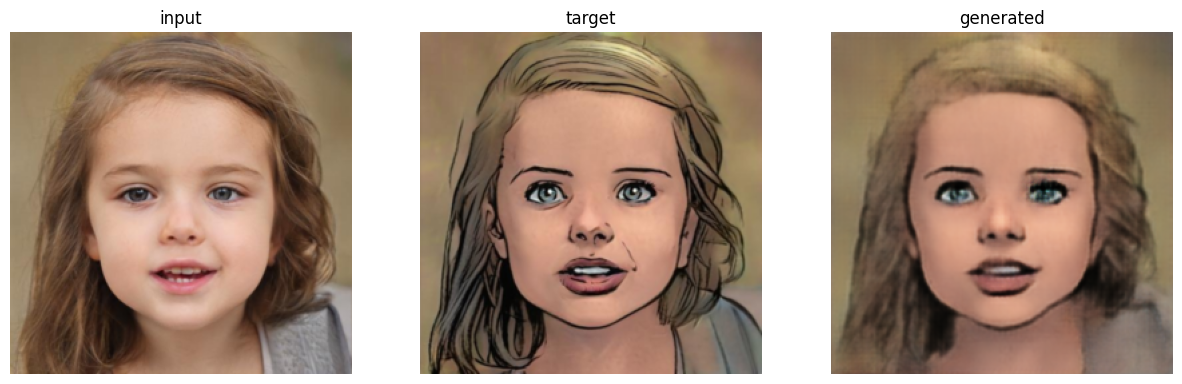

In [39]:
validate(val_input, val_target, generator)

Training epoch 23


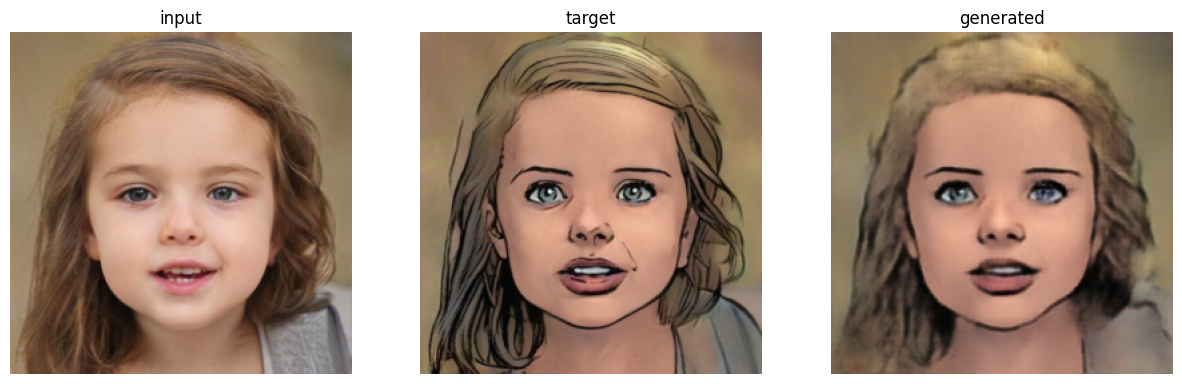

 14%|█▍        | 86/625 [06:03<38:00,  4.23s/it]  


KeyboardInterrupt: 

In [40]:
for epoch in range(11,NUM_EPOCHS+1):
     
     
     display.clear_output(wait=True)
     print(f"Training epoch {epoch+1}")
     validate(val_input, val_target, generator)

     for images,_ in tqdm(dataloader_train):
          inputs = images[:,:,:,:256].to(device)
          targets = images[:,:,:,256:].to(device)

          Disc_Loss = discriminator_training(inputs,targets,discriminator_opt)

          for i in range(2):
               Gen_Loss, generator_image = generator_training(inputs,targets, generator_opt, L1_lambda)

     if (epoch % 5) == 0:
          checkpoint = {"generator": generator.state_dict(), "gen_opt": generator_opt.state_dict(), "discriminator": discriminator.state_dict(),
          "disc_opt": discriminator_opt.state_dict()}

          torch.save(checkpoint, f"models/pix2pix_{epoch}.pt")

<Figure size 640x480 with 0 Axes>

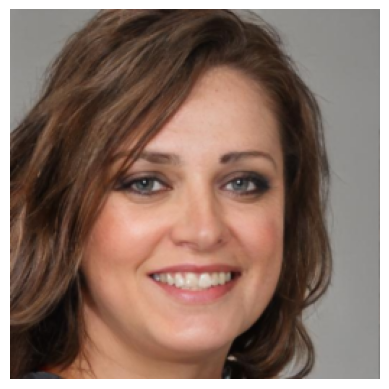

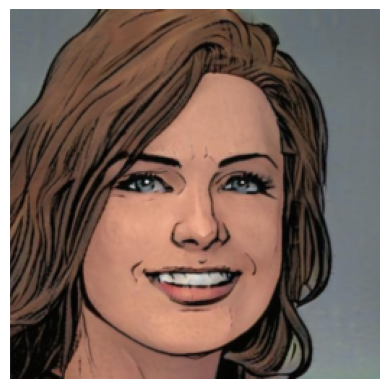

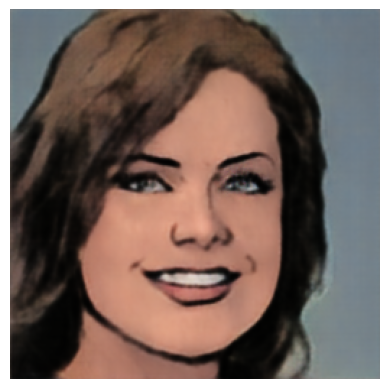

<Figure size 640x480 with 0 Axes>

In [51]:
test_imgs,_ = next(iter(dataloader_val))


input_img = test_imgs[:,:,:,:256].to(device)
real_img = test_imgs[:,:,:,256:].to(device)

gen_img = generator(input_img)

input_img = input_img.detach().cpu()
gen_img = gen_img.detach().cpu()
real_img = real_img.detach().cpu()

plt.imshow(input_img.permute(0,2,3,1).cpu().numpy()[0]*0.5+0.5)
plt.axis("off")
plt.figure()
plt.imshow(real_img.permute(0,2,3,1).cpu().numpy()[0]*0.5+0.5)
plt.axis("off")
plt.figure()
plt.imshow(gen_img.permute(0,2,3,1).cpu().numpy()[0]*0.5+0.5)
plt.axis("off")
plt.figure()
